# Autoencoders

- CNN takes an input image and transforms the image into a much smaller (X,Y)dimensions that can also be seen as a structure for data compression. Along the way, CNN also discard some spatial information, at the same time isolating high level information about its content.

- Thus, CNN basically takes an input image in form of a feature vector and takes out spatial information from them in form of feature maps. This part which can be used to reconstruct back the original image using the feature maps is called as autoencoder.

- A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation.

- The architectures of both encoder and decoder are in form of neural networks and the training process involves minimizing the difference between input and output. The key aspect of autoencoders is to keep the same quality of content in form of compressed representation.


## Linear Autoencoder

![alt-text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

(Image Credit: Keras Blog)

With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data.

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# Convert Data to Torch Tensors
transform = transforms.ToTensor()

# Load Training and Testing Data
train_data = datasets.MNIST(root='data', train=True, download=True, 
                            transform=transform)

test_data = datasets.MNIST(root='data', train=False, download=True, 
                           transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
# Number of Subprocesses used for loading
num_workers = 0

# Number of training or testing instances sent in one epoch
batch_size = 20

# Training and Testing Data Loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers) 

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

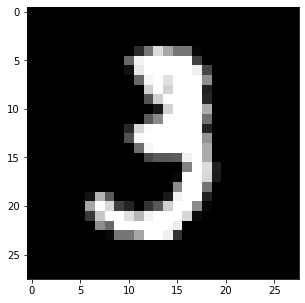

In [4]:
# Visualising the data

import matplotlib.pyplot as plt

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[10])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

A simple autoencoder can take normalized images as input to its encoder-decoder architecture made up of **single layer** of neural networks and try to reconstruct the original input. 

The units that connect the encoder to the decoder is the compressed representation of the image, such that it constrains the amount of information which can traverse the full network, forcing a learned compression of the input data. This is known as a **bottleneck**.

A bottleneck is a key attribute in the autoencoders because in its absence, the network will just memorize the input values, and become a rote-learned network that overfits on the training instances.

![alt-text](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png)

(Image Credit: Jeremy Jordan's Blog)

In the case of MNIST, we have 28*28 sized input images which amount upto 784 pixels of data, that has to be reconstructed.

![alt-text](https://viewb3dohjcrq1f.udacity-student-workspaces.com/files/notebook_ims/simple_autoencoder.png)

(Image Credit: Udacity)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# neural network architecture

class Autoencoder(nn.Module):
  def __init__(self, encoding_dimension):
    super(Autoencoder, self).__init__()

    ## Encoder
    self.fc1 = nn.Linear(28*28, encoding_dimension)

    ## Decoder
    self.fc2 = nn.Linear(encoding_dimension, 28*28)

  def forward(self, x):
    # Feed Forward the neural network
    x = F.relu(self.fc1(x))
    # Scale the output in range 0-1
    x = F.sigmoid(self.fc2(x))

    return x

encoding_dim = 64
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=784, bias=True)
)


## Training 

For a simple autoencoder, we are comparing pixels from input and output images, hence it becomes suitable to use a loss function similar to regression tasks such as Mean Squared Loss.
Thus, a simple loss function can be:

**loss = criterion(outputs, images)**

Regression is all about comparing quantities rather than probabilistic values, and hence we make a pretty straightforward autoencoder that takes inputs images, flattens them, runs a network and evaluates the loss on the pixel values through simple comparison.

In [6]:
# Specify loss function
criterion = nn.MSELoss()
# Specify Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [12]:
# Number of Training Epochs
n_epochs = 25

for epoch in range(1, n_epochs+1):
  # Training Loss
  train_loss = 0.0

  for data in train_loader:

    # _ = labels
    images, _ = data

    # flatten the images
    images = images.view(images.size(0), -1)
    # initialize gradients to zero
    optimizer.zero_grad()
    # forward pass
    outputs = model(images)
    # compute loss
    loss = criterion(outputs, images)
    # backward pass
    loss.backward()
    # parameter updates
    optimizer.step()
    # compute updated loss
    train_loss += loss.item()*images.size(0)

  train_loss = train_loss/len(train_loader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.144329
Epoch: 2 	Training Loss: 0.571354
Epoch: 3 	Training Loss: 0.403283
Epoch: 4 	Training Loss: 0.313283
Epoch: 5 	Training Loss: 0.255931
Epoch: 6 	Training Loss: 0.215494
Epoch: 7 	Training Loss: 0.185945
Epoch: 8 	Training Loss: 0.164107
Epoch: 9 	Training Loss: 0.147761
Epoch: 10 	Training Loss: 0.135287
Epoch: 11 	Training Loss: 0.125576
Epoch: 12 	Training Loss: 0.117920
Epoch: 13 	Training Loss: 0.111865
Epoch: 14 	Training Loss: 0.106985
Epoch: 15 	Training Loss: 0.102975
Epoch: 16 	Training Loss: 0.099628
Epoch: 17 	Training Loss: 0.096801
Epoch: 18 	Training Loss: 0.094392
Epoch: 19 	Training Loss: 0.092320
Epoch: 20 	Training Loss: 0.090527
Epoch: 21 	Training Loss: 0.088964
Epoch: 22 	Training Loss: 0.087595
Epoch: 23 	Training Loss: 0.086390
Epoch: 24 	Training Loss: 0.085325
Epoch: 25 	Training Loss: 0.084380


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


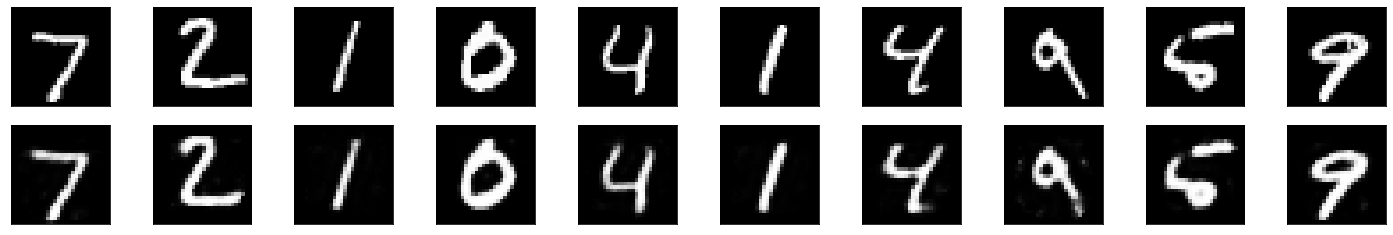

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Convolutional Autoencoder

- The idea of a decoder is that we need to increase the spatial dimensions of the compressed representation in order to obtain the original input image or close enough to it. Thus, instead of downsampling using maxpooling we can simply use an interpolation technique, for example, nearest-neighbors or linear interpolation to increase the dimensions of the compressed representation or the bottleneck.

- The realistic larger images has much more complexity that cannot be handled by linear interpolation. Hence, we make use of transposed convolutional layer which does not use a predefined interpolation method, and has learnable parameters. It makes use of filter weights to increase the dimensions of image.

- Deconvolution involves multiplying a single pixel value of the bottleneck with a filter that yields a resultant area. For example, we make use of a 3*3 filter on one pixel then we get a 3*3 area and when we do the same thing for all four pixels in a 2*2 image then we get a 5*5 output which overlaps with each others.

- If we combine the idea of upsampling using nearest neighbors for interpolation with the idea of deconvolution then we get a denoised and a much clearer output from the compressed representation.

Hence, let us try to improve the performance of the autoencoder using convolutional layers.

![alt-text](https://viewcz8akq85t5i.udacity-student-workspaces.com/files/notebook_ims/conv_enc_1.png)
(Image Credits: Udacity)


In [8]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()

    # Encoder Layers

    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)


    # Decoder Layers

    self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)


    x = F.relu(self.t_conv1(x))
    x = F.sigmoid(self.t_conv2(x))
    return x

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [9]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
n_epochs = 30
for epoch in range(1, n_epochs+1):
  train_loss = 0.0

  for data in train_loader:
    # input images and unknown labels
    images, _ = data

    # making all the gradients as zero
    optimizer.zero_grad()
    # forward pass the images
    outputs = model(images)
    # calculate the loss
    loss = criterion(outputs, images)
    # backward pass
    loss.backward()
    # perform parameter updation
    optimizer.step()
    train_loss += loss.item()*images.size(0)

  train_loss = train_loss/len(train_loader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.578046
Epoch: 2 	Training Loss: 0.297937
Epoch: 3 	Training Loss: 0.276346
Epoch: 4 	Training Loss: 0.262458
Epoch: 5 	Training Loss: 0.254944
Epoch: 6 	Training Loss: 0.250068
Epoch: 7 	Training Loss: 0.246468
Epoch: 8 	Training Loss: 0.243659
Epoch: 9 	Training Loss: 0.240975
Epoch: 10 	Training Loss: 0.237913
Epoch: 11 	Training Loss: 0.234556
Epoch: 12 	Training Loss: 0.231964
Epoch: 13 	Training Loss: 0.230035
Epoch: 14 	Training Loss: 0.228303
Epoch: 15 	Training Loss: 0.226792
Epoch: 16 	Training Loss: 0.225538
Epoch: 17 	Training Loss: 0.224430
Epoch: 18 	Training Loss: 0.223395
Epoch: 19 	Training Loss: 0.222426
Epoch: 20 	Training Loss: 0.221516
Epoch: 21 	Training Loss: 0.220681
Epoch: 22 	Training Loss: 0.219940
Epoch: 23 	Training Loss: 0.219303
Epoch: 24 	Training Loss: 0.218774
Epoch: 25 	Training Loss: 0.218322
Epoch: 26 	Training Loss: 0.217943
Epoch: 27 	Training Loss: 0.217611
Epoch: 28 	Training Loss: 0.217336
Epoch: 29 	Training Loss: 0.2

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


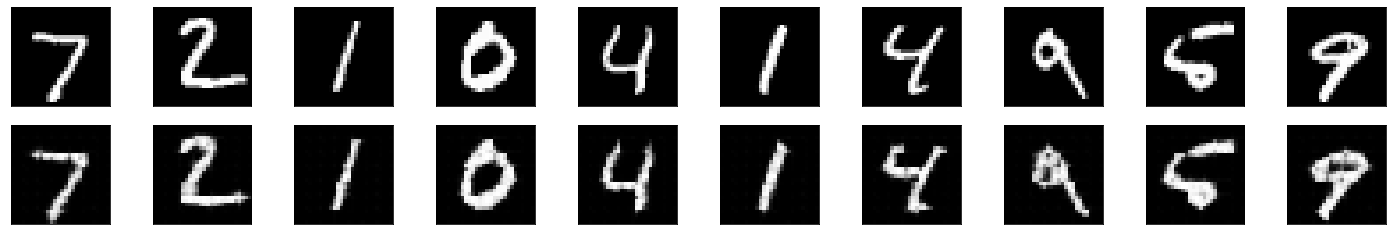

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Denoising Autoencoder

It is well known that autoencoders can be used to get compressed representation of images, however we can also use the same to reconstruct non-noisy images from noisy representations using autoencoders.

- Encoder learns to distill information from the input image.
- Decoder can learn to construct non-noisy images.

Hence, we try to create a deeper network and will feed noisy input images using a salt-pepper noise filter and try to reconstruct clearer images with the help of the network.
![alt-text](https://viewfg84g2jma2g.udacity-student-workspaces.com/files/notebook_ims/denoising.png)


In [17]:
class ConvDenoisingAutoEncoder(nn.Module):
  def __init__(self):
    super(ConvDenoisingAutoEncoder, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
    self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
    self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
    self.convout = nn.Conv2d(32, 1, 3, padding=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)
    x = F.relu(self.conv3(x))
    x = self.maxpool(x)
    x = F.relu(self.t_conv1(x))
    x = F.relu(self.t_conv2(x))
    x = F.relu(self.t_conv3(x))
    x = F.sigmoid(self.convout(x))
    return x
model = ConvDenoisingAutoEncoder()
print(model)

ConvDenoisingAutoEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (convout): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [18]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.647940
Epoch: 2 	Training Loss: 0.577711
Epoch: 3 	Training Loss: 0.538427
Epoch: 4 	Training Loss: 0.512286
Epoch: 5 	Training Loss: 0.495798
Epoch: 6 	Training Loss: 0.484783
Epoch: 7 	Training Loss: 0.475639
Epoch: 8 	Training Loss: 0.470185
Epoch: 9 	Training Loss: 0.464307
Epoch: 10 	Training Loss: 0.460265
Epoch: 11 	Training Loss: 0.455967
Epoch: 12 	Training Loss: 0.452160
Epoch: 13 	Training Loss: 0.448594
Epoch: 14 	Training Loss: 0.446097
Epoch: 15 	Training Loss: 0.443050
Epoch: 16 	Training Loss: 0.440170
Epoch: 17 	Training Loss: 0.437558
Epoch: 18 	Training Loss: 0.434294
Epoch: 19 	Training Loss: 0.431963
Epoch: 20 	Training Loss: 0.430230


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


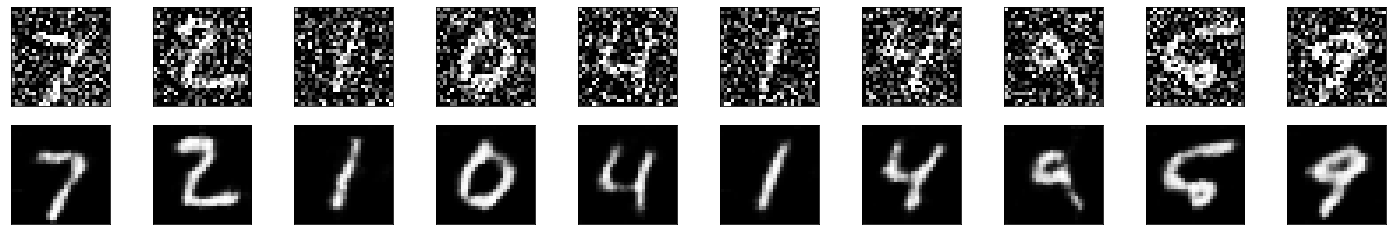

In [21]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)